In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

from tensorflow.keras.utils import plot_model

#tensorboard: currently some error
#!pip install -U tensorboardcolab
#from tensorboardcolab import *

# json and pretty print
import json
import pprint
# to persist the numpy arrays data
import h5py
# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

print(tf.__version__)
df_ibuprofen = pd.read_csv('data/ibuprofen.csv')
print(df_ibuprofen.dtypes.value_counts())
print(df_ibuprofen.columns.tolist())
print('length of columns :', len(df_ibuprofen.columns.tolist()))
print(df_ibuprofen.count())
df_ibuprofen.head()

1.12.0
float64    2
object     1
int64      1
dtype: int64
['dateUnix', 'dateIso', 'kgPrice', 'quantity']
length of columns : 4
dateUnix    3978
dateIso     3978
kgPrice     3978
quantity    3978
dtype: int64


,dateUnix,dateIso,kgPrice,quantity
0,1483311600,1/1/2017,15.111767,20000.0
1,1483311600,1/1/2017,12.697010,3000.0
2,1483311600,1/1/2017,9.700000,6500.0
3,1483311600,1/1/2017,11.347700,4000.0
4,1483311600,1/1/2017,9.347750,1000.0


# Functions

In [2]:
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):\
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])
  
def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    # Get Daily errors
    
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, color='black', label = 'Original data') 
    plt1.plot(predicted, color='blue', label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')
    
    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

# returns normalized dataset between a and b
def minmax_norm(dataset, a, b):
    # NORMALIZE DATASET
    d = dataset
    mi = np.min(dataset)
    ma = np.max(dataset)

    norm_dataset = ((b-a) * ((d - mi)/(ma - mi))) + a
    return norm_dataset

def minmax_denorm(old_data, val, a=-1, b=1):
    mi = min(old_data)
    ma = max(old_data)

    return ((val - a) * (ma-mi) / (b-a)) + mi

def get_test(X, percentage=0.9):
    iXPercentage = int(len(X) * percentage) 
    X_train_val = X[0:iXPercentage]
    X_test = X[iXPercentage:]
    return X_train_val, X_test
  
def get_data_dict(d_list, windows):
    length = len(d_list[0])
    step = 1
    forecast = 1

    _dict = {}
    for window in windows:
        X = []
        Y = []
        for i in range(0, length, step):
            try:
                # Get windowed data
                windowed_features_list = []
                for j in range(len(d_list)):
                    windowed_features_list.append(d_list[j][i:i+window])

                # ALWAYS TAKE THE FIRST data 
                y_i = d_list[0][i + window + forecast - 1] # indexing is important.
                x_i = np.column_stack(tuple(windowed_features_list))
            except Exception as e:
                print(e)
                break
            
            X.append(x_i)
            Y.append(y_i)
            #print(X)
        _dict[window] = {'X': np.array(X), 'Y': np.array(Y)}
    
    return _dict

In [4]:
dataset = df_ibuprofen.copy()
dataset = dataset.drop("dateIso", axis=1)
dataset.head()

,dateUnix,kgPrice,quantity
0,1483311600,15.111767,20000.0
1,1483311600,12.697010,3000.0
2,1483311600,9.700000,6500.0
3,1483311600,11.347700,4000.0
4,1483311600,9.347750,1000.0


In [5]:
def fn(group):
    group['weighted_avg_kgprice'] = group['kgPrice'] * group['quantity'] / group['quantity'].sum()
    return group

d_agg = {'weighted_avg_kgprice':'sum', 
         'quantity':'sum'
        }

dataset_weighted = dataset.groupby('dateUnix', sort=False).apply(fn).groupby('dateUnix').agg(d_agg)
dataset_weighted.head(15)
#dataset_weighted

#print(dataset.groupby('dateUnix', sort=False).apply(fn))

,weighted_avg_kgprice,quantity
dateUnix,,
1483311600,12.405626,46350.0
1483398000,11.801926,2300.0
1483484400,11.687077,15550.0
1483657200,19.074012,9850.0
1483743600,13.525167,17850.0
1483916400,11.601642,6700.0
1484002800,13.449941,5100.0
1484089200,9.697000,2000.0
1484175600,11.347700,6000.0


In [6]:
column_names = ['weighted_avg_kgprice', 'quantity']

In [7]:
prices = np.array(dataset_weighted[column_names[0]])
volumes = np.array(dataset_weighted[column_names[1]])
#print(prices)
#print(volumes)

In [8]:
non_normalized_data = get_data_dict(d_list=[prices, volumes], windows=[6, 8, 12])

x = non_normalized_data[6]['X']
y = non_normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 604 is out of bounds for axis 0 with size 604
index 604 is out of bounds for axis 0 with size 604
index 604 is out of bounds for axis 0 with size 604
[[1.24056261e+01 4.63500000e+04]
 [1.18019263e+01 2.30000000e+03]
 [1.16870766e+01 1.55500000e+04]
 [1.90740122e+01 9.85000000e+03]
 [1.35251668e+01 1.78500000e+04]
 [1.16016418e+01 6.70000000e+03]]
13.449940979411764
****************************************************************************************************
[[1.18019263e+01 2.30000000e+03]
 [1.16870766e+01 1.55500000e+04]
 [1.90740122e+01 9.85000000e+03]
 [1.35251668e+01 1.78500000e+04]
 [1.16016418e+01 6.70000000e+03]
 [1.34499410e+01 5.10000000e+03]]
9.697000000000001
****************************************************************************************************


In [9]:
# Extract Test
daily_prices, test_daily_prices = get_test(prices)
daily_volumes, test_daily_volumes = get_test(volumes)
#print(len(daily_prices))
print(daily_prices.shape)

(543,)


In [10]:
data_dict = get_data_dict(d_list=[daily_prices, daily_volumes], 
                                windows=[6,8,12])
x = data_dict[6]['X']
y = data_dict[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 543 is out of bounds for axis 0 with size 543
index 543 is out of bounds for axis 0 with size 543
index 543 is out of bounds for axis 0 with size 543
[[1.24056261e+01 4.63500000e+04]
 [1.18019263e+01 2.30000000e+03]
 [1.16870766e+01 1.55500000e+04]
 [1.90740122e+01 9.85000000e+03]
 [1.35251668e+01 1.78500000e+04]
 [1.16016418e+01 6.70000000e+03]]
13.449940979411764
****************************************************************************************************
[[1.18019263e+01 2.30000000e+03]
 [1.16870766e+01 1.55500000e+04]
 [1.90740122e+01 9.85000000e+03]
 [1.35251668e+01 1.78500000e+04]
 [1.16016418e+01 6.70000000e+03]
 [1.34499410e+01 5.10000000e+03]]
9.697000000000001
****************************************************************************************************


In [11]:
norm_daily_prices  = minmax_norm(daily_prices, a=-1, b=1)
norm_daily_volumes = minmax_norm(daily_volumes, a=-1, b=1)

normalized_data = get_data_dict(d_list=[norm_daily_prices, norm_daily_volumes], 
                                windows=[6,8,12])

index 543 is out of bounds for axis 0 with size 543
index 543 is out of bounds for axis 0 with size 543
index 543 is out of bounds for axis 0 with size 543


In [12]:
x = normalized_data[6]['X']
y = normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

[[-0.87220573 -0.17859738]
 [-0.89165045 -0.95930737]
 [-0.89534968 -0.72447406]
 [-0.65742202 -0.82549669]
 [-0.83614617 -0.68371054]
 [-0.89810147 -0.88132499]]
-0.8385691356658009
****************************************************************************************************
[[-0.89165045 -0.95930737]
 [-0.89534968 -0.72447406]
 [-0.65742202 -0.82549669]
 [-0.83614617 -0.68371054]
 [-0.89810147 -0.88132499]
 [-0.83856914 -0.90968222]]
-0.9594485531590177
****************************************************************************************************


# BI-DIR LSTM

In [14]:
w = 6
#w = 8
#w = 12
batch_size = 32

In [15]:
def build_model(tensor_shape):
    #create model
    model = keras.Sequential()
    units = tensor_shape[0]
    #model.add(layers.Bidirectional(LSTM(units, return_sequences=True, activation='relu'), input_shape=(tensor_shape[0], tensor_shape[1])))
    model.add(layers.Bidirectional(LSTM(units, return_sequences=True), batch_input_shape=(None, tensor_shape[0], tensor_shape[1])))
    
    
    #model.add(layers.Bidirectional(layers.LSTM(5, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]))))
    #model.add(layers.LSTM(4, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(layers.LSTM(32, activation='relu'))
    model.add(Flatten())
    model.add(layers.Dense(1))
    #optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    return model

In [16]:
model = build_model(tensor_shape=(w, 2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 6, 12)             432       
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


In [17]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_ibuprofen_price_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)    

Model will be saved at: models/bidirlstm_multivariate_model_ibuprofen_price_norm.h5


In [18]:
def get_train_validation(X, y, percentage=0.8):
    iXPercentage = int(len(X) * percentage) 
    iYPercentage = int(len(y) * percentage)
    X_train = X[0:iXPercentage]
    Y_train = y[0:iYPercentage]
    
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_val = X[iXPercentage:]
    Y_val = y[iYPercentage:]
    return X_train, X_val, Y_train, Y_val

In [19]:
nX = normalized_data[w]['X']
nY = normalized_data[w]['Y']
X_train, X_val, Y_train, Y_val = get_train_validation(nX, nY)

In [20]:
print('X_train: '+str(X_train.shape))
print('X_val: '+str(X_val.shape))

X_train: (429, 6, 2)
X_val: (108, 6, 2)


In [21]:
print(X_train[0])
print(Y_train[0])
print('*'*50)
print(X_train[1])
print(Y_train[1])
print('*'*50)

[[-0.87220573 -0.17859738]
 [-0.89165045 -0.95930737]
 [-0.89534968 -0.72447406]
 [-0.65742202 -0.82549669]
 [-0.83614617 -0.68371054]
 [-0.89810147 -0.88132499]]
-0.8385691356658009
**************************************************
[[-0.89165045 -0.95930737]
 [-0.89534968 -0.72447406]
 [-0.65742202 -0.82549669]
 [-0.83614617 -0.68371054]
 [-0.89810147 -0.88132499]
 [-0.83856914 -0.90968222]]
-0.9594485531590177
**************************************************


In [22]:
history = model.fit(X_train, Y_train, 
                    epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val, Y_val), validation_split=0.8, callbacks=callbacks)

Train on 429 samples, validate on 108 samples
Epoch 1/1000
384/429 [=========================>....] - ETA: 0s - loss: 0.3287 - mean_absolute_error: 0.5687 - mean_squared_error: 0.3287 - mean_absolute_percentage_error: 65.7095
Epoch 00001: val_loss improved from inf to 0.25601, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_norm.h5
429/429 [==============================] - 6s 14ms/step - loss: 0.3330 - mean_absolute_error: 0.5714 - mean_squared_error: 0.3330 - mean_absolute_percentage_error: 65.9789 - val_loss: 0.2560 - val_mean_absolute_error: 0.4936 - val_mean_squared_error: 0.2560 - val_mean_absolute_percentage_error: 62.9964
Epoch 2/1000
384/429 [=========================>....] - ETA: 0s - loss: 0.3088 - mean_absolute_error: 0.5501 - mean_squared_error: 0.3088 - mean_absolute_percentage_error: 63.5066
Epoch 00002: val_loss improved from 0.25601 to 0.23626, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_norm.h5
429/429 [=====================

384/429 [=========================>....] - ETA: 0s - loss: 0.0233 - mean_absolute_error: 0.1121 - mean_squared_error: 0.0233 - mean_absolute_percentage_error: 12.9247
Epoch 00027: val_loss improved from 0.01750 to 0.01614, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_norm.h5
429/429 [==============================] - 0s 846us/step - loss: 0.0224 - mean_absolute_error: 0.1122 - mean_squared_error: 0.0224 - mean_absolute_percentage_error: 12.9309 - val_loss: 0.0161 - val_mean_absolute_error: 0.1004 - val_mean_squared_error: 0.0161 - val_mean_absolute_percentage_error: 14.2671
Epoch 28/1000
384/429 [=========================>....] - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.1055 - mean_squared_error: 0.0218 - mean_absolute_percentage_error: 12.2192
Epoch 00028: val_loss improved from 0.01614 to 0.01507, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_norm.h5
429/429 [==============================] - 0s 874us/step - loss: 0.0205 - mean_abso

Epoch 41/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0574 - mean_squared_error: 0.0143 - mean_absolute_percentage_error: 6.9455
Epoch 00041: val_loss did not improve from 0.01234
429/429 [==============================] - 0s 752us/step - loss: 0.0139 - mean_absolute_error: 0.0570 - mean_squared_error: 0.0139 - mean_absolute_percentage_error: 6.8854 - val_loss: 0.0124 - val_mean_absolute_error: 0.0783 - val_mean_squared_error: 0.0124 - val_mean_absolute_percentage_error: 12.2782
Epoch 42/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0570 - mean_squared_error: 0.0142 - mean_absolute_percentage_error: 6.9076
Epoch 00042: val_loss did not improve from 0.01234
429/429 [==============================] - 0s 757us/step - loss: 0.0139 - mean_absolute_error: 0.0564 - mean_squared_error: 0.0139 - mean_absolute_percentage_error: 6.8250 - val_loss: 0.0125 - val_mean_absolute_error: 0.0782 - val_mea

Epoch 72/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0487 - mean_squared_error: 0.0054 - mean_absolute_percentage_error: 5.8915
Epoch 00072: val_loss did not improve from 0.01234
429/429 [==============================] - 0s 794us/step - loss: 0.0137 - mean_absolute_error: 0.0537 - mean_squared_error: 0.0137 - mean_absolute_percentage_error: 6.5664 - val_loss: 0.0126 - val_mean_absolute_error: 0.0778 - val_mean_squared_error: 0.0126 - val_mean_absolute_percentage_error: 12.3351
Epoch 73/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0539 - mean_squared_error: 0.0140 - mean_absolute_percentage_error: 6.5954
Epoch 00073: val_loss did not improve from 0.01234
429/429 [==============================] - 0s 783us/step - loss: 0.0137 - mean_absolute_error: 0.0538 - mean_squared_error: 0.0137 - mean_absolute_percentage_error: 6.5779 - val_loss: 0.0125 - val_mean_absolute_error: 0.0776 - val_mea

352/429 [=======================>......] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.0545 - mean_squared_error: 0.0155 - mean_absolute_percentage_error: 6.7186
Epoch 00102: val_loss did not improve from 0.01234
429/429 [==============================] - 0s 796us/step - loss: 0.0136 - mean_absolute_error: 0.0532 - mean_squared_error: 0.0136 - mean_absolute_percentage_error: 6.5109 - val_loss: 0.0124 - val_mean_absolute_error: 0.0770 - val_mean_squared_error: 0.0124 - val_mean_absolute_percentage_error: 12.2319
Epoch 103/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0527 - mean_squared_error: 0.0137 - mean_absolute_percentage_error: 6.4244
Epoch 00103: val_loss did not improve from 0.01234
429/429 [==============================] - 0s 749us/step - loss: 0.0136 - mean_absolute_error: 0.0532 - mean_squared_error: 0.0136 - mean_absolute_percentage_error: 6.5120 - val_loss: 0.0124 - val_mean_absolute_error: 0.0770 - val_mean_squared_err

416/429 [============================>.] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0537 - mean_squared_error: 0.0139 - mean_absolute_percentage_error: 6.5795
Epoch 00117: val_loss did not improve from 0.01233
429/429 [==============================] - 0s 779us/step - loss: 0.0135 - mean_absolute_error: 0.0531 - mean_squared_error: 0.0135 - mean_absolute_percentage_error: 6.4898 - val_loss: 0.0123 - val_mean_absolute_error: 0.0766 - val_mean_squared_error: 0.0123 - val_mean_absolute_percentage_error: 12.1774
Epoch 118/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0536 - mean_squared_error: 0.0139 - mean_absolute_percentage_error: 6.5654
Epoch 00118: val_loss did not improve from 0.01233
429/429 [==============================] - 0s 772us/step - loss: 0.0135 - mean_absolute_error: 0.0530 - mean_squared_error: 0.0135 - mean_absolute_percentage_error: 6.4838 - val_loss: 0.0124 - val_mean_absolute_error: 0.0767 - val_mean_squared_err

Epoch 132/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0522 - mean_squared_error: 0.0133 - mean_absolute_percentage_error: 6.3961
Epoch 00132: val_loss did not improve from 0.01224
429/429 [==============================] - 0s 764us/step - loss: 0.0135 - mean_absolute_error: 0.0529 - mean_squared_error: 0.0135 - mean_absolute_percentage_error: 6.4677 - val_loss: 0.0123 - val_mean_absolute_error: 0.0763 - val_mean_squared_error: 0.0123 - val_mean_absolute_percentage_error: 12.1306
Epoch 133/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0534 - mean_squared_error: 0.0138 - mean_absolute_percentage_error: 6.5333
Epoch 00133: val_loss did not improve from 0.01224
429/429 [==============================] - 0s 802us/step - loss: 0.0135 - mean_absolute_error: 0.0528 - mean_squared_error: 0.0135 - mean_absolute_percentage_error: 6.4554 - val_loss: 0.0123 - val_mean_absolute_error: 0.0763 - val_m

384/429 [=========================>....] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0530 - mean_squared_error: 0.0140 - mean_absolute_percentage_error: 6.4902
Epoch 00162: val_loss did not improve from 0.01213
429/429 [==============================] - 0s 754us/step - loss: 0.0134 - mean_absolute_error: 0.0524 - mean_squared_error: 0.0134 - mean_absolute_percentage_error: 6.4068 - val_loss: 0.0122 - val_mean_absolute_error: 0.0756 - val_mean_squared_error: 0.0122 - val_mean_absolute_percentage_error: 12.0595
Epoch 163/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0524 - mean_squared_error: 0.0137 - mean_absolute_percentage_error: 6.4306
Epoch 00163: val_loss did not improve from 0.01213
429/429 [==============================] - 0s 759us/step - loss: 0.0134 - mean_absolute_error: 0.0522 - mean_squared_error: 0.0134 - mean_absolute_percentage_error: 6.3920 - val_loss: 0.0122 - val_mean_absolute_error: 0.0756 - val_mean_squared_err

Epoch 177/1000
384/429 [=========================>....] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0515 - mean_squared_error: 0.0142 - mean_absolute_percentage_error: 6.2853
Epoch 00177: val_loss did not improve from 0.01210
429/429 [==============================] - 0s 911us/step - loss: 0.0133 - mean_absolute_error: 0.0521 - mean_squared_error: 0.0133 - mean_absolute_percentage_error: 6.3778 - val_loss: 0.0121 - val_mean_absolute_error: 0.0752 - val_mean_squared_error: 0.0121 - val_mean_absolute_percentage_error: 12.0109
Epoch 178/1000
384/429 [=========================>....] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0524 - mean_squared_error: 0.0142 - mean_absolute_percentage_error: 6.3790
Epoch 00178: val_loss improved from 0.01210 to 0.01209, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_norm.h5
429/429 [==============================] - 0s 921us/step - loss: 0.0133 - mean_absolute_error: 0.0521 - mean_squared_error: 0.0133 - mean_absolute_perc

Epoch 192/1000
384/429 [=========================>....] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0526 - mean_squared_error: 0.0137 - mean_absolute_percentage_error: 6.2839
Epoch 00192: val_loss improved from 0.01205 to 0.01194, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0524 - mean_squared_error: 0.0133 - mean_absolute_percentage_error: 6.4071 - val_loss: 0.0119 - val_mean_absolute_error: 0.0746 - val_mean_squared_error: 0.0119 - val_mean_absolute_percentage_error: 11.9038
Epoch 193/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0528 - mean_squared_error: 0.0136 - mean_absolute_percentage_error: 6.4566
Epoch 00193: val_loss did not improve from 0.01194
429/429 [==============================] - 1s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0523 - mean_squared_error: 0.0133 - mean_absolute_percenta

Epoch 222/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0512 - mean_squared_error: 0.0132 - mean_absolute_percentage_error: 6.2889
Epoch 00222: val_loss did not improve from 0.01192
429/429 [==============================] - 0s 715us/step - loss: 0.0132 - mean_absolute_error: 0.0516 - mean_squared_error: 0.0132 - mean_absolute_percentage_error: 6.3186 - val_loss: 0.0120 - val_mean_absolute_error: 0.0741 - val_mean_squared_error: 0.0120 - val_mean_absolute_percentage_error: 11.8816
Epoch 223/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0520 - mean_squared_error: 0.0136 - mean_absolute_percentage_error: 6.3980
Epoch 00223: val_loss did not improve from 0.01192
429/429 [==============================] - 0s 763us/step - loss: 0.0132 - mean_absolute_error: 0.0514 - mean_squared_error: 0.0132 - mean_absolute_percentage_error: 6.3019 - val_loss: 0.0120 - val_mean_absolute_error: 0.0742 - val_m

Epoch 237/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0511 - mean_squared_error: 0.0133 - mean_absolute_percentage_error: 6.2810
Epoch 00237: val_loss did not improve from 0.01180
429/429 [==============================] - 0s 1ms/step - loss: 0.0132 - mean_absolute_error: 0.0514 - mean_squared_error: 0.0132 - mean_absolute_percentage_error: 6.2979 - val_loss: 0.0120 - val_mean_absolute_error: 0.0738 - val_mean_squared_error: 0.0120 - val_mean_absolute_percentage_error: 11.8671
Epoch 238/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0514 - mean_squared_error: 0.0135 - mean_absolute_percentage_error: 6.3147
Epoch 00238: val_loss did not improve from 0.01180
429/429 [==============================] - 1s 1ms/step - loss: 0.0131 - mean_absolute_error: 0.0511 - mean_squared_error: 0.0131 - mean_absolute_percentage_error: 6.2768 - val_loss: 0.0120 - val_mean_absolute_error: 0.0738 - val_mean_

352/429 [=======================>......] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0497 - mean_squared_error: 0.0141 - mean_absolute_percentage_error: 5.8264
Epoch 00252: val_loss did not improve from 0.01171
429/429 [==============================] - 0s 874us/step - loss: 0.0131 - mean_absolute_error: 0.0512 - mean_squared_error: 0.0131 - mean_absolute_percentage_error: 6.2810 - val_loss: 0.0119 - val_mean_absolute_error: 0.0733 - val_mean_squared_error: 0.0119 - val_mean_absolute_percentage_error: 11.8016
Epoch 253/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0518 - mean_squared_error: 0.0134 - mean_absolute_percentage_error: 6.3491
Epoch 00253: val_loss did not improve from 0.01171
429/429 [==============================] - 0s 781us/step - loss: 0.0131 - mean_absolute_error: 0.0516 - mean_squared_error: 0.0131 - mean_absolute_percentage_error: 6.3102 - val_loss: 0.0118 - val_mean_absolute_error: 0.0731 - val_mean_squared_err

416/429 [============================>.] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0514 - mean_squared_error: 0.0134 - mean_absolute_percentage_error: 6.3101
Epoch 00282: val_loss did not improve from 0.01171
429/429 [==============================] - 0s 744us/step - loss: 0.0130 - mean_absolute_error: 0.0509 - mean_squared_error: 0.0130 - mean_absolute_percentage_error: 6.2432 - val_loss: 0.0118 - val_mean_absolute_error: 0.0727 - val_mean_squared_error: 0.0118 - val_mean_absolute_percentage_error: 11.7241
Epoch 283/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0518 - mean_squared_error: 0.0134 - mean_absolute_percentage_error: 6.3597
Epoch 00283: val_loss did not improve from 0.01171
429/429 [==============================] - 0s 735us/step - loss: 0.0130 - mean_absolute_error: 0.0511 - mean_squared_error: 0.0130 - mean_absolute_percentage_error: 6.2588 - val_loss: 0.0118 - val_mean_absolute_error: 0.0727 - val_mean_squared_err

416/429 [============================>.] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0518 - mean_squared_error: 0.0133 - mean_absolute_percentage_error: 6.3443
Epoch 00297: val_loss did not improve from 0.01161
429/429 [==============================] - 0s 862us/step - loss: 0.0130 - mean_absolute_error: 0.0514 - mean_squared_error: 0.0130 - mean_absolute_percentage_error: 6.2841 - val_loss: 0.0117 - val_mean_absolute_error: 0.0723 - val_mean_squared_error: 0.0117 - val_mean_absolute_percentage_error: 11.6690
Epoch 298/1000
352/429 [=======================>......] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0476 - mean_squared_error: 0.0054 - mean_absolute_percentage_error: 5.9962
Epoch 00298: val_loss did not improve from 0.01161
429/429 [==============================] - 0s 898us/step - loss: 0.0130 - mean_absolute_error: 0.0508 - mean_squared_error: 0.0130 - mean_absolute_percentage_error: 6.2269 - val_loss: 0.0119 - val_mean_absolute_error: 0.0727 - val_mean_squared_err

416/429 [============================>.] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0513 - mean_squared_error: 0.0133 - mean_absolute_percentage_error: 6.2937
Epoch 00327: val_loss did not improve from 0.01156
429/429 [==============================] - 0s 730us/step - loss: 0.0129 - mean_absolute_error: 0.0507 - mean_squared_error: 0.0129 - mean_absolute_percentage_error: 6.2147 - val_loss: 0.0117 - val_mean_absolute_error: 0.0719 - val_mean_squared_error: 0.0117 - val_mean_absolute_percentage_error: 11.6368
Epoch 328/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0463 - mean_squared_error: 0.0051 - mean_absolute_percentage_error: 5.7842
Epoch 00328: val_loss did not improve from 0.01156
429/429 [==============================] - 0s 744us/step - loss: 0.0129 - mean_absolute_error: 0.0505 - mean_squared_error: 0.0129 - mean_absolute_percentage_error: 6.1989 - val_loss: 0.0118 - val_mean_absolute_error: 0.0721 - val_mean_squared_err

416/429 [============================>.] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0501 - mean_squared_error: 0.0131 - mean_absolute_percentage_error: 6.1561
Epoch 00357: val_loss did not improve from 0.01156
429/429 [==============================] - 0s 751us/step - loss: 0.0129 - mean_absolute_error: 0.0502 - mean_squared_error: 0.0129 - mean_absolute_percentage_error: 6.1618 - val_loss: 0.0117 - val_mean_absolute_error: 0.0714 - val_mean_squared_error: 0.0117 - val_mean_absolute_percentage_error: 11.5934
Epoch 358/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0509 - mean_squared_error: 0.0131 - mean_absolute_percentage_error: 6.2294
Epoch 00358: val_loss did not improve from 0.01156
429/429 [==============================] - 0s 725us/step - loss: 0.0129 - mean_absolute_error: 0.0509 - mean_squared_error: 0.0129 - mean_absolute_percentage_error: 6.2246 - val_loss: 0.0116 - val_mean_absolute_error: 0.0710 - val_mean_squared_err

416/429 [============================>.] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0505 - mean_squared_error: 0.0132 - mean_absolute_percentage_error: 6.2207
Epoch 00387: val_loss did not improve from 0.01140
429/429 [==============================] - 0s 736us/step - loss: 0.0128 - mean_absolute_error: 0.0498 - mean_squared_error: 0.0128 - mean_absolute_percentage_error: 6.1224 - val_loss: 0.0118 - val_mean_absolute_error: 0.0712 - val_mean_squared_error: 0.0118 - val_mean_absolute_percentage_error: 11.5953
Epoch 388/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0508 - mean_squared_error: 0.0132 - mean_absolute_percentage_error: 6.2473
Epoch 00388: val_loss did not improve from 0.01140
429/429 [==============================] - 0s 742us/step - loss: 0.0128 - mean_absolute_error: 0.0500 - mean_squared_error: 0.0128 - mean_absolute_percentage_error: 6.1413 - val_loss: 0.0117 - val_mean_absolute_error: 0.0710 - val_mean_squared_err

352/429 [=======================>......] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0511 - mean_squared_error: 0.0146 - mean_absolute_percentage_error: 6.2563
Epoch 00417: val_loss did not improve from 0.01140
429/429 [==============================] - 0s 925us/step - loss: 0.0127 - mean_absolute_error: 0.0500 - mean_squared_error: 0.0127 - mean_absolute_percentage_error: 6.1395 - val_loss: 0.0118 - val_mean_absolute_error: 0.0708 - val_mean_squared_error: 0.0118 - val_mean_absolute_percentage_error: 11.5549
Epoch 418/1000
384/429 [=========================>....] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0503 - mean_squared_error: 0.0136 - mean_absolute_percentage_error: 6.1835
Epoch 00418: val_loss did not improve from 0.01140
429/429 [==============================] - 0s 809us/step - loss: 0.0127 - mean_absolute_error: 0.0500 - mean_squared_error: 0.0127 - mean_absolute_percentage_error: 6.1358 - val_loss: 0.0117 - val_mean_absolute_error: 0.0705 - val_mean_squared_err

416/429 [============================>.] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0490 - mean_squared_error: 0.0128 - mean_absolute_percentage_error: 5.9902
Epoch 00447: val_loss did not improve from 0.01140
429/429 [==============================] - 0s 858us/step - loss: 0.0127 - mean_absolute_error: 0.0497 - mean_squared_error: 0.0127 - mean_absolute_percentage_error: 6.1031 - val_loss: 0.0118 - val_mean_absolute_error: 0.0706 - val_mean_squared_error: 0.0118 - val_mean_absolute_percentage_error: 11.5599
Epoch 448/1000
384/429 [=========================>....] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0503 - mean_squared_error: 0.0138 - mean_absolute_percentage_error: 6.2200
Epoch 00448: val_loss did not improve from 0.01140
429/429 [==============================] - 0s 787us/step - loss: 0.0127 - mean_absolute_error: 0.0496 - mean_squared_error: 0.0127 - mean_absolute_percentage_error: 6.0956 - val_loss: 0.0118 - val_mean_absolute_error: 0.0705 - val_mean_squared_err

In [23]:
model.evaluate(X_val, Y_val)

108/108 [==============================] - 0s 3ms/step


[0.011731395635891843,
 0.07009343195844579,
 0.011731395635891843,
 11.484676149156359]

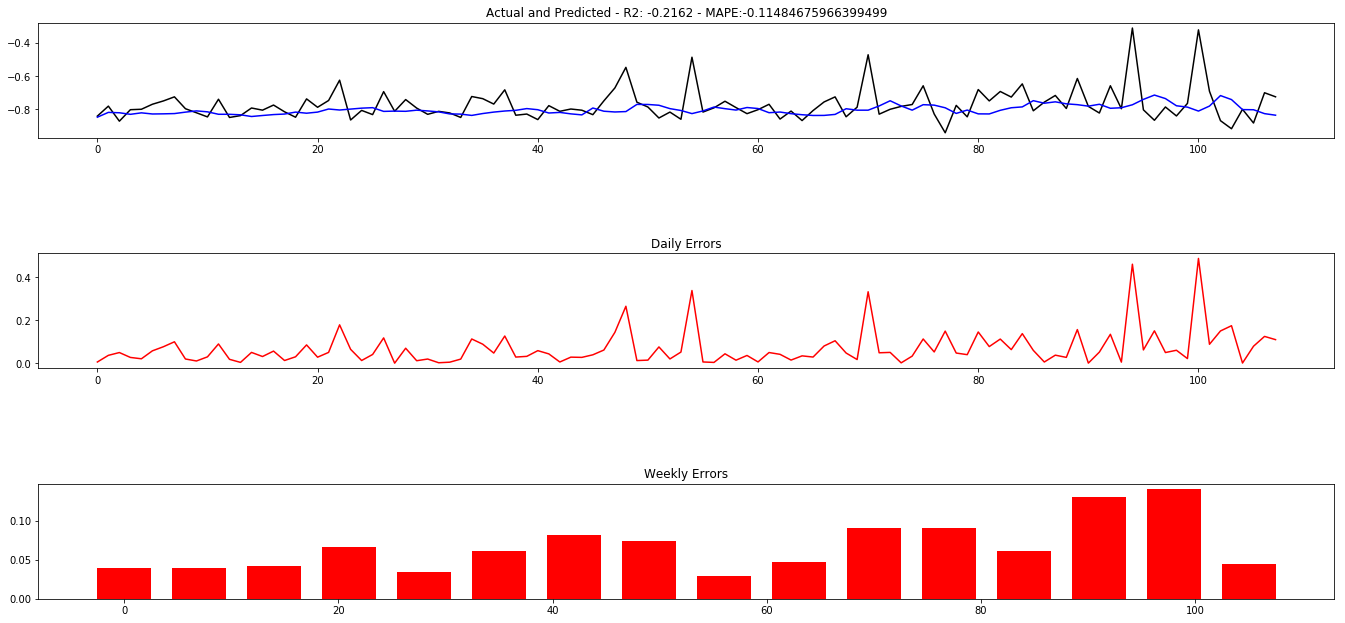

In [24]:
 plot_prediction(Y_val, model.predict(X_val))

# TEST

In [25]:
norm_test_daily_prices = minmax_norm(test_daily_prices, a=-1, b=1)
norm_test_daily_volumes = minmax_norm(test_daily_volumes, a=-1, b=1)

# Not Normalized

In [26]:
#normalized d_list
d_list = [test_daily_prices, test_daily_volumes]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61


# Normalized

In [27]:
#normalized d_list
d_list = [norm_test_daily_prices, norm_test_daily_volumes]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

norm_test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    norm_test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61


In [28]:
X_test = norm_test_data_dict[w]['X']
#Y_test = test_data_dict[w]['Y']
not_norm_true_values = test_data_dict[w]['Y']

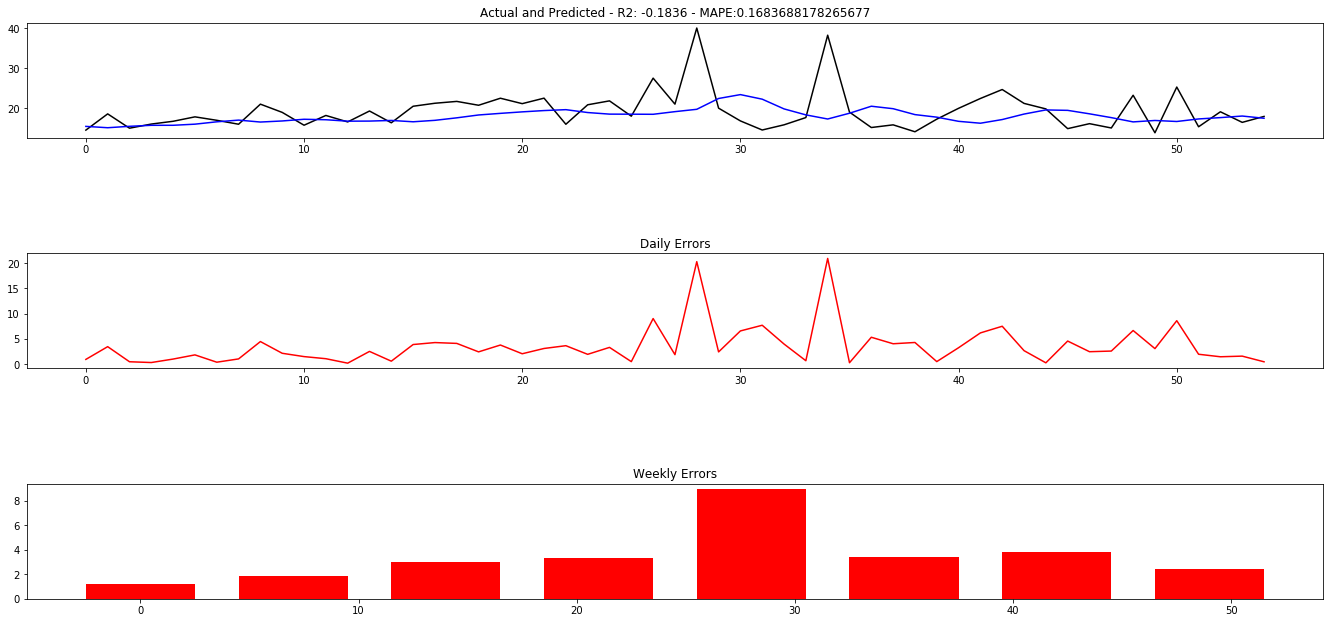

In [29]:
pred_y = model.predict(X_test)
pred_yy = minmax_denorm(test_daily_prices, pred_y, a=-1, b=1)
plot_prediction(not_norm_true_values, pred_yy)

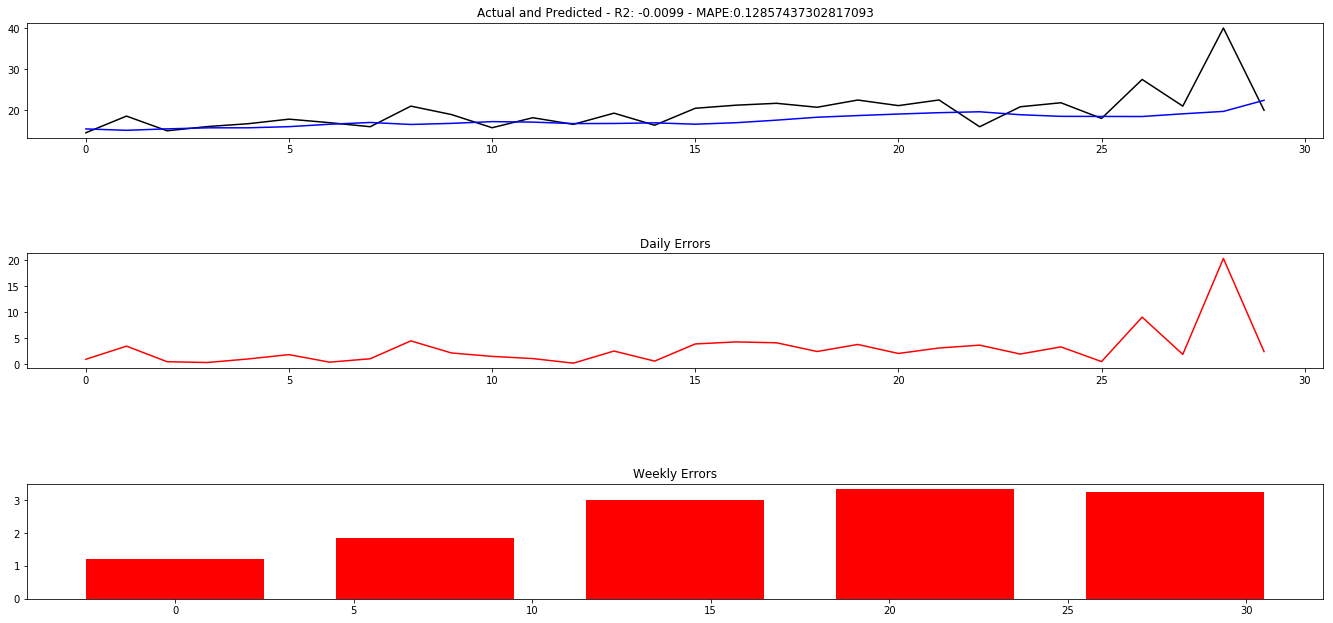

In [30]:
t=0
tp = 30
plot_prediction(not_norm_true_values[t:t+tp], pred_yy[t:t+tp])

# Training with Non-Normalized Data

In [31]:
nX_ = data_dict[w]['X']
nY_ = data_dict[w]['Y']
X_train_, X_val_, Y_train_, Y_val_ = get_train_validation(nX_, nY_)

In [32]:
print('X_train_: '+str(X_train_.shape))
print('X_val_: '+str(X_val_.shape))

X_train_: (429, 6, 2)
X_val_: (108, 6, 2)


In [33]:
print(X_train_[0])
print(Y_train_[0])
print('*'*50)
print(X_train_[1])
print(Y_train_[1])
print('*'*50)

[[1.24056261e+01 4.63500000e+04]
 [1.18019263e+01 2.30000000e+03]
 [1.16870766e+01 1.55500000e+04]
 [1.90740122e+01 9.85000000e+03]
 [1.35251668e+01 1.78500000e+04]
 [1.16016418e+01 6.70000000e+03]]
13.449940979411764
**************************************************
[[1.18019263e+01 2.30000000e+03]
 [1.16870766e+01 1.55500000e+04]
 [1.90740122e+01 9.85000000e+03]
 [1.35251668e+01 1.78500000e+04]
 [1.16016418e+01 6.70000000e+03]
 [1.34499410e+01 5.10000000e+03]]
9.697000000000001
**************************************************


In [34]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)

Model will be saved at: models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5


In [35]:
history = model.fit(X_train_, Y_train_, epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val_, Y_val_), validation_split=0.8, callbacks=callbacks)

Train on 429 samples, validate on 108 samples
Epoch 1/1000
416/429 [============================>.] - ETA: 0s - loss: 172.3047 - mean_absolute_error: 12.6491 - mean_squared_error: 172.3047 - mean_absolute_percentage_error: 98.1624
Epoch 00001: val_loss improved from inf to 244.23237, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 2s 6ms/step - loss: 171.2308 - mean_absolute_error: 12.6174 - mean_squared_error: 171.2308 - mean_absolute_percentage_error: 98.1528 - val_loss: 244.2324 - val_mean_absolute_error: 15.3276 - val_mean_squared_error: 244.2324 - val_mean_absolute_percentage_error: 98.3156
Epoch 2/1000
384/429 [=========================>....] - ETA: 0s - loss: 171.0466 - mean_absolute_error: 12.5719 - mean_squared_error: 171.0466 - mean_absolute_percentage_error: 97.8096
Epoch 00002: val_loss improved from 244.23237 to 242.81481, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5

Epoch 14/1000
384/429 [=========================>....] - ETA: 0s - loss: 158.3893 - mean_absolute_error: 12.0522 - mean_squared_error: 158.3893 - mean_absolute_percentage_error: 93.4020
Epoch 00014: val_loss improved from 227.61480 to 226.28843, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 852us/step - loss: 156.5626 - mean_absolute_error: 12.0226 - mean_squared_error: 156.5626 - mean_absolute_percentage_error: 93.3827 - val_loss: 226.2884 - val_mean_absolute_error: 14.7306 - val_mean_squared_error: 226.2884 - val_mean_absolute_percentage_error: 94.3715
Epoch 15/1000
416/429 [============================>.] - ETA: 0s - loss: 156.0195 - mean_absolute_error: 11.9877 - mean_squared_error: 156.0195 - mean_absolute_percentage_error: 93.0241
Epoch 00015: val_loss improved from 226.28843 to 224.96134, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==========================

Epoch 27/1000
416/429 [============================>.] - ETA: 0s - loss: 143.6762 - mean_absolute_error: 11.4610 - mean_squared_error: 143.6762 - mean_absolute_percentage_error: 88.7589
Epoch 00027: val_loss improved from 210.80395 to 209.55140, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 1ms/step - loss: 142.9880 - mean_absolute_error: 11.4446 - mean_squared_error: 142.9880 - mean_absolute_percentage_error: 88.7452 - val_loss: 209.5514 - val_mean_absolute_error: 14.1511 - val_mean_squared_error: 209.5514 - val_mean_absolute_percentage_error: 90.5429
Epoch 28/1000
416/429 [============================>.] - ETA: 0s - loss: 140.9336 - mean_absolute_error: 11.3531 - mean_squared_error: 140.9336 - mean_absolute_percentage_error: 88.3625
Epoch 00028: val_loss improved from 209.55140 to 208.30669, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [============================

Epoch 40/1000
416/429 [============================>.] - ETA: 0s - loss: 129.8399 - mean_absolute_error: 10.8504 - mean_squared_error: 129.8399 - mean_absolute_percentage_error: 84.1817
Epoch 00040: val_loss improved from 194.99548 to 193.81818, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 802us/step - loss: 130.3528 - mean_absolute_error: 10.8785 - mean_squared_error: 130.3528 - mean_absolute_percentage_error: 84.2038 - val_loss: 193.8182 - val_mean_absolute_error: 13.5838 - val_mean_squared_error: 193.8182 - val_mean_absolute_percentage_error: 86.7951
Epoch 41/1000
416/429 [============================>.] - ETA: 0s - loss: 129.8888 - mean_absolute_error: 10.8434 - mean_squared_error: 129.8888 - mean_absolute_percentage_error: 83.8656
Epoch 00041: val_loss improved from 193.81818 to 192.65788, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==========================

Epoch 53/1000
416/429 [============================>.] - ETA: 0s - loss: 119.3835 - mean_absolute_error: 10.3483 - mean_squared_error: 119.3835 - mean_absolute_percentage_error: 79.7888
Epoch 00053: val_loss improved from 180.17177 to 179.07262, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 830us/step - loss: 118.6132 - mean_absolute_error: 10.3253 - mean_squared_error: 118.6132 - mean_absolute_percentage_error: 79.7651 - val_loss: 179.0726 - val_mean_absolute_error: 13.0298 - val_mean_squared_error: 179.0726 - val_mean_absolute_percentage_error: 83.1345
Epoch 54/1000
416/429 [============================>.] - ETA: 0s - loss: 118.2316 - mean_absolute_error: 10.2951 - mean_squared_error: 118.2316 - mean_absolute_percentage_error: 79.4503
Epoch 00054: val_loss improved from 179.07262 to 177.98645, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==========================

Epoch 66/1000
416/429 [============================>.] - ETA: 0s - loss: 107.7669 - mean_absolute_error: 9.7702 - mean_squared_error: 107.7669 - mean_absolute_percentage_error: 75.3971
Epoch 00066: val_loss improved from 166.30296 to 165.27145, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 830us/step - loss: 107.7499 - mean_absolute_error: 9.7854 - mean_squared_error: 107.7499 - mean_absolute_percentage_error: 75.4348 - val_loss: 165.2714 - val_mean_absolute_error: 12.4889 - val_mean_squared_error: 165.2714 - val_mean_absolute_percentage_error: 79.5614
Epoch 67/1000
416/429 [============================>.] - ETA: 0s - loss: 106.5708 - mean_absolute_error: 9.7198 - mean_squared_error: 106.5708 - mean_absolute_percentage_error: 75.0695
Epoch 00067: val_loss improved from 165.27145 to 164.24494, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [=============================

Epoch 79/1000
416/429 [============================>.] - ETA: 0s - loss: 98.5175 - mean_absolute_error: 9.2862 - mean_squared_error: 98.5175 - mean_absolute_percentage_error: 71.2525  
Epoch 00079: val_loss improved from 153.30354 to 152.34266, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 837us/step - loss: 97.6927 - mean_absolute_error: 9.2575 - mean_squared_error: 97.6927 - mean_absolute_percentage_error: 71.1981 - val_loss: 152.3427 - val_mean_absolute_error: 11.9601 - val_mean_squared_error: 152.3427 - val_mean_absolute_percentage_error: 76.0678
Epoch 80/1000
416/429 [============================>.] - ETA: 0s - loss: 97.7754 - mean_absolute_error: 9.2453 - mean_squared_error: 97.7754 - mean_absolute_percentage_error: 70.9295  
Epoch 00080: val_loss improved from 152.34266 to 151.38357, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================]

Epoch 92/1000
416/429 [============================>.] - ETA: 0s - loss: 88.6816 - mean_absolute_error: 8.7415 - mean_squared_error: 88.6816 - mean_absolute_percentage_error: 67.0505
Epoch 00092: val_loss improved from 141.15465 to 140.24684, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 1ms/step - loss: 88.4059 - mean_absolute_error: 8.7416 - mean_squared_error: 88.4059 - mean_absolute_percentage_error: 67.0588 - val_loss: 140.2468 - val_mean_absolute_error: 11.4433 - val_mean_squared_error: 140.2468 - val_mean_absolute_percentage_error: 72.6531
Epoch 93/1000
416/429 [============================>.] - ETA: 0s - loss: 88.3369 - mean_absolute_error: 8.7201 - mean_squared_error: 88.3369 - mean_absolute_percentage_error: 66.7647
Epoch 00093: val_loss improved from 140.24684 to 139.35351, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 

Epoch 105/1000
416/429 [============================>.] - ETA: 0s - loss: 80.1442 - mean_absolute_error: 8.2421 - mean_squared_error: 80.1442 - mean_absolute_percentage_error: 63.0263
Epoch 00105: val_loss improved from 129.79526 to 128.94999, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 820us/step - loss: 79.8449 - mean_absolute_error: 8.2374 - mean_squared_error: 79.8449 - mean_absolute_percentage_error: 63.0134 - val_loss: 128.9500 - val_mean_absolute_error: 10.9385 - val_mean_squared_error: 128.9500 - val_mean_absolute_percentage_error: 69.3185
Epoch 106/1000
416/429 [============================>.] - ETA: 0s - loss: 80.0215 - mean_absolute_error: 8.2296 - mean_squared_error: 80.0215 - mean_absolute_percentage_error: 62.7739
Epoch 00106: val_loss improved from 128.94999 to 128.11664, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] -

Epoch 118/1000
416/429 [============================>.] - ETA: 0s - loss: 73.0325 - mean_absolute_error: 7.7976 - mean_squared_error: 73.0325 - mean_absolute_percentage_error: 59.2237
Epoch 00118: val_loss improved from 119.19814 to 118.41532, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 837us/step - loss: 71.9621 - mean_absolute_error: 7.7446 - mean_squared_error: 71.9621 - mean_absolute_percentage_error: 59.0577 - val_loss: 118.4153 - val_mean_absolute_error: 10.4459 - val_mean_squared_error: 118.4153 - val_mean_absolute_percentage_error: 66.0638
Epoch 119/1000
416/429 [============================>.] - ETA: 0s - loss: 71.5072 - mean_absolute_error: 7.6969 - mean_squared_error: 71.5072 - mean_absolute_percentage_error: 58.7076
Epoch 00119: val_loss improved from 118.41532 to 117.63614, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] -

Epoch 131/1000
416/429 [============================>.] - ETA: 0s - loss: 64.6188 - mean_absolute_error: 7.2434 - mean_squared_error: 64.6188 - mean_absolute_percentage_error: 55.1366
Epoch 00131: val_loss improved from 109.33757 to 108.61092, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 835us/step - loss: 64.7429 - mean_absolute_error: 7.2638 - mean_squared_error: 64.7429 - mean_absolute_percentage_error: 55.2008 - val_loss: 108.6109 - val_mean_absolute_error: 9.9656 - val_mean_squared_error: 108.6109 - val_mean_absolute_percentage_error: 62.8903
Epoch 132/1000
416/429 [============================>.] - ETA: 0s - loss: 64.5563 - mean_absolute_error: 7.2289 - mean_squared_error: 64.5563 - mean_absolute_percentage_error: 54.8920
Epoch 00132: val_loss improved from 108.61092 to 107.87615, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 

Epoch 144/1000
416/429 [============================>.] - ETA: 0s - loss: 58.7169 - mean_absolute_error: 6.8132 - mean_squared_error: 58.7169 - mean_absolute_percentage_error: 51.4757
Epoch 00144: val_loss improved from 100.15131 to 99.47177, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 858us/step - loss: 58.1368 - mean_absolute_error: 6.7936 - mean_squared_error: 58.1368 - mean_absolute_percentage_error: 51.4263 - val_loss: 99.4718 - val_mean_absolute_error: 9.4960 - val_mean_squared_error: 99.4718 - val_mean_absolute_percentage_error: 59.7878
Epoch 145/1000
416/429 [============================>.] - ETA: 0s - loss: 58.1493 - mean_absolute_error: 6.7710 - mean_squared_error: 58.1493 - mean_absolute_percentage_error: 51.1596
Epoch 00145: val_loss improved from 99.47177 to 98.78936, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 95

416/429 [============================>.] - ETA: 0s - loss: 52.0499 - mean_absolute_error: 6.3218 - mean_squared_error: 52.0499 - mean_absolute_percentage_error: 47.7107
Epoch 00157: val_loss improved from 91.61218 to 90.98924, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 876us/step - loss: 52.1177 - mean_absolute_error: 6.3351 - mean_squared_error: 52.1177 - mean_absolute_percentage_error: 47.7455 - val_loss: 90.9892 - val_mean_absolute_error: 9.0383 - val_mean_squared_error: 90.9892 - val_mean_absolute_percentage_error: 56.7641
Epoch 158/1000
416/429 [============================>.] - ETA: 0s - loss: 52.3306 - mean_absolute_error: 6.3263 - mean_squared_error: 52.3306 - mean_absolute_percentage_error: 47.5415
Epoch 00158: val_loss improved from 90.98924 to 90.35391, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 836us/step - loss:

416/429 [============================>.] - ETA: 0s - loss: 42.0390 - mean_absolute_error: 5.4597 - mean_squared_error: 42.0390 - mean_absolute_percentage_error: 40.6885
Epoch 00183: val_loss improved from 76.40596 to 75.86663, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 866us/step - loss: 41.7465 - mean_absolute_error: 5.4544 - mean_squared_error: 41.7465 - mean_absolute_percentage_error: 40.6746 - val_loss: 75.8666 - val_mean_absolute_error: 8.1589 - val_mean_squared_error: 75.8666 - val_mean_absolute_percentage_error: 50.9544
Epoch 184/1000
416/429 [============================>.] - ETA: 0s - loss: 41.8129 - mean_absolute_error: 5.4318 - mean_squared_error: 41.8129 - mean_absolute_percentage_error: 40.4282
Epoch 00184: val_loss improved from 75.86663 to 75.33456, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 863us/step - loss:

384/429 [=========================>....] - ETA: 0s - loss: 34.5430 - mean_absolute_error: 4.6264 - mean_squared_error: 34.5430 - mean_absolute_percentage_error: 33.8945
Epoch 00209: val_loss improved from 63.50344 to 63.05224, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 874us/step - loss: 33.3715 - mean_absolute_error: 4.6229 - mean_squared_error: 33.3715 - mean_absolute_percentage_error: 33.9997 - val_loss: 63.0522 - val_mean_absolute_error: 7.3317 - val_mean_squared_error: 63.0522 - val_mean_absolute_percentage_error: 45.4891
Epoch 210/1000
416/429 [============================>.] - ETA: 0s - loss: 33.1285 - mean_absolute_error: 4.5800 - mean_squared_error: 33.1285 - mean_absolute_percentage_error: 33.6915
Epoch 00210: val_loss improved from 63.05224 to 62.60636, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 860us/step - loss:

Epoch 222/1000
384/429 [=========================>....] - ETA: 0s - loss: 30.9374 - mean_absolute_error: 4.2432 - mean_squared_error: 30.9374 - mean_absolute_percentage_error: 30.8483
Epoch 00222: val_loss improved from 57.85013 to 57.44326, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 853us/step - loss: 29.8769 - mean_absolute_error: 4.2296 - mean_squared_error: 29.8769 - mean_absolute_percentage_error: 30.8461 - val_loss: 57.4433 - val_mean_absolute_error: 6.9387 - val_mean_squared_error: 57.4433 - val_mean_absolute_percentage_error: 42.8923
Epoch 223/1000
416/429 [============================>.] - ETA: 0s - loss: 29.7906 - mean_absolute_error: 4.2056 - mean_squared_error: 29.7906 - mean_absolute_percentage_error: 30.6572
Epoch 00223: val_loss improved from 57.44326 to 57.02977, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 856

416/429 [============================>.] - ETA: 0s - loss: 27.1242 - mean_absolute_error: 3.8583 - mean_squared_error: 27.1242 - mean_absolute_percentage_error: 27.8435
Epoch 00235: val_loss improved from 52.69697 to 52.32395, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 863us/step - loss: 26.8106 - mean_absolute_error: 3.8522 - mean_squared_error: 26.8106 - mean_absolute_percentage_error: 27.8269 - val_loss: 52.3240 - val_mean_absolute_error: 6.5594 - val_mean_squared_error: 52.3240 - val_mean_absolute_percentage_error: 40.3866
Epoch 236/1000
416/429 [============================>.] - ETA: 0s - loss: 26.5750 - mean_absolute_error: 3.7986 - mean_squared_error: 26.5750 - mean_absolute_percentage_error: 27.4644
Epoch 00236: val_loss improved from 52.32395 to 51.94876, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 860us/step - loss:

384/429 [=========================>....] - ETA: 0s - loss: 22.0397 - mean_absolute_error: 3.0859 - mean_squared_error: 22.0397 - mean_absolute_percentage_error: 21.8399
Epoch 00261: val_loss improved from 43.76956 to 43.45853, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 860us/step - loss: 21.8168 - mean_absolute_error: 3.1447 - mean_squared_error: 21.8168 - mean_absolute_percentage_error: 22.1767 - val_loss: 43.4585 - val_mean_absolute_error: 5.8447 - val_mean_squared_error: 43.4585 - val_mean_absolute_percentage_error: 35.6646
Epoch 262/1000
384/429 [=========================>....] - ETA: 0s - loss: 22.4251 - mean_absolute_error: 3.1213 - mean_squared_error: 22.4251 - mean_absolute_percentage_error: 21.9691
Epoch 00262: val_loss improved from 43.45853 to 43.15323, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 867us/step - loss:

384/429 [=========================>....] - ETA: 0s - loss: 18.5728 - mean_absolute_error: 2.5145 - mean_squared_error: 18.5728 - mean_absolute_percentage_error: 17.2068
Epoch 00287: val_loss improved from 36.52272 to 36.27825, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 861us/step - loss: 18.1547 - mean_absolute_error: 2.5307 - mean_squared_error: 18.1547 - mean_absolute_percentage_error: 17.3371 - val_loss: 36.2783 - val_mean_absolute_error: 5.1959 - val_mean_squared_error: 36.2783 - val_mean_absolute_percentage_error: 31.3831
Epoch 288/1000
416/429 [============================>.] - ETA: 0s - loss: 18.2187 - mean_absolute_error: 2.5180 - mean_squared_error: 18.2187 - mean_absolute_percentage_error: 17.2426
Epoch 00288: val_loss improved from 36.27825 to 36.02556, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 842us/step - loss:

Epoch 313/1000
384/429 [=========================>....] - ETA: 0s - loss: 16.0091 - mean_absolute_error: 2.0757 - mean_squared_error: 16.0091 - mean_absolute_percentage_error: 13.9583
Epoch 00313: val_loss improved from 30.78207 to 30.58857, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 864us/step - loss: 15.6007 - mean_absolute_error: 2.0803 - mean_squared_error: 15.6007 - mean_absolute_percentage_error: 13.9551 - val_loss: 30.5886 - val_mean_absolute_error: 4.6265 - val_mean_squared_error: 30.5886 - val_mean_absolute_percentage_error: 27.6550
Epoch 314/1000
416/429 [============================>.] - ETA: 0s - loss: 15.7185 - mean_absolute_error: 2.0595 - mean_squared_error: 15.7185 - mean_absolute_percentage_error: 13.8019
Epoch 00314: val_loss improved from 30.58857 to 30.39866, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 900

Epoch 326/1000
416/429 [============================>.] - ETA: 0s - loss: 15.0383 - mean_absolute_error: 1.9401 - mean_squared_error: 15.0383 - mean_absolute_percentage_error: 12.9184
Epoch 00326: val_loss improved from 28.43535 to 28.26162, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 846us/step - loss: 14.6832 - mean_absolute_error: 1.9270 - mean_squared_error: 14.6832 - mean_absolute_percentage_error: 12.8857 - val_loss: 28.2616 - val_mean_absolute_error: 4.3752 - val_mean_squared_error: 28.2616 - val_mean_absolute_percentage_error: 26.0173
Epoch 327/1000
416/429 [============================>.] - ETA: 0s - loss: 14.9851 - mean_absolute_error: 1.9341 - mean_squared_error: 14.9851 - mean_absolute_percentage_error: 12.8977
Epoch 00327: val_loss improved from 28.26162 to 28.09533, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 873

416/429 [============================>.] - ETA: 0s - loss: 14.2135 - mean_absolute_error: 1.8156 - mean_squared_error: 14.2135 - mean_absolute_percentage_error: 12.1413
Epoch 00339: val_loss improved from 26.36477 to 26.21480, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 878us/step - loss: 13.9453 - mean_absolute_error: 1.8108 - mean_squared_error: 13.9453 - mean_absolute_percentage_error: 12.1273 - val_loss: 26.2148 - val_mean_absolute_error: 4.1424 - val_mean_squared_error: 26.2148 - val_mean_absolute_percentage_error: 24.5043
Epoch 340/1000
416/429 [============================>.] - ETA: 0s - loss: 14.0948 - mean_absolute_error: 1.8057 - mean_squared_error: 14.0948 - mean_absolute_percentage_error: 12.0869
Epoch 00340: val_loss improved from 26.21480 to 26.06591, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 849us/step - loss:

Epoch 365/1000
384/429 [=========================>....] - ETA: 0s - loss: 13.4553 - mean_absolute_error: 1.6754 - mean_squared_error: 13.4553 - mean_absolute_percentage_error: 11.3691
Epoch 00365: val_loss improved from 23.03849 to 22.93877, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 867us/step - loss: 12.9445 - mean_absolute_error: 1.6700 - mean_squared_error: 12.9445 - mean_absolute_percentage_error: 11.3414 - val_loss: 22.9388 - val_mean_absolute_error: 3.7383 - val_mean_squared_error: 22.9388 - val_mean_absolute_percentage_error: 21.8775
Epoch 366/1000
416/429 [============================>.] - ETA: 0s - loss: 13.2871 - mean_absolute_error: 1.6906 - mean_squared_error: 13.2871 - mean_absolute_percentage_error: 11.4551
Epoch 00366: val_loss improved from 22.93877 to 22.82493, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 851

384/429 [=========================>....] - ETA: 0s - loss: 13.6239 - mean_absolute_error: 1.6437 - mean_squared_error: 13.6239 - mean_absolute_percentage_error: 11.1681
Epoch 00378: val_loss improved from 21.74995 to 21.65912, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 828us/step - loss: 12.6309 - mean_absolute_error: 1.6284 - mean_squared_error: 12.6309 - mean_absolute_percentage_error: 11.1607 - val_loss: 21.6591 - val_mean_absolute_error: 3.5674 - val_mean_squared_error: 21.6591 - val_mean_absolute_percentage_error: 20.7664
Epoch 379/1000
384/429 [=========================>....] - ETA: 0s - loss: 13.8418 - mean_absolute_error: 1.6781 - mean_squared_error: 13.8418 - mean_absolute_percentage_error: 11.3054
Epoch 00379: val_loss improved from 21.65912 to 21.57757, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 842us/step - loss:

416/429 [============================>.] - ETA: 0s - loss: 12.2984 - mean_absolute_error: 1.5711 - mean_squared_error: 12.2984 - mean_absolute_percentage_error: 11.0216
Epoch 00404: val_loss improved from 19.78262 to 19.71613, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 853us/step - loss: 12.2504 - mean_absolute_error: 1.5922 - mean_squared_error: 12.2504 - mean_absolute_percentage_error: 11.1272 - val_loss: 19.7161 - val_mean_absolute_error: 3.2944 - val_mean_squared_error: 19.7161 - val_mean_absolute_percentage_error: 18.9998
Epoch 405/1000
416/429 [============================>.] - ETA: 0s - loss: 12.3734 - mean_absolute_error: 1.5877 - mean_squared_error: 12.3734 - mean_absolute_percentage_error: 11.1377
Epoch 00405: val_loss improved from 19.71613 to 19.65423, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 853us/step - loss:

416/429 [============================>.] - ETA: 0s - loss: 12.3139 - mean_absolute_error: 1.5820 - mean_squared_error: 12.3139 - mean_absolute_percentage_error: 11.2381
Epoch 00430: val_loss improved from 18.45525 to 18.41544, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 851us/step - loss: 12.0774 - mean_absolute_error: 1.5857 - mean_squared_error: 12.0774 - mean_absolute_percentage_error: 11.2625 - val_loss: 18.4154 - val_mean_absolute_error: 3.1004 - val_mean_squared_error: 18.4154 - val_mean_absolute_percentage_error: 17.7500
Epoch 431/1000
416/429 [============================>.] - ETA: 0s - loss: 12.3918 - mean_absolute_error: 1.5987 - mean_squared_error: 12.3918 - mean_absolute_percentage_error: 11.3412
Epoch 00431: val_loss improved from 18.41544 to 18.38441, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 834us/step - loss:

352/429 [=======================>......] - ETA: 0s - loss: 4.4904 - mean_absolute_error: 1.4809 - mean_squared_error: 4.4904 - mean_absolute_percentage_error: 11.3533
Epoch 00456: val_loss improved from 17.58558 to 17.57680, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 870us/step - loss: 12.0052 - mean_absolute_error: 1.5924 - mean_squared_error: 12.0052 - mean_absolute_percentage_error: 11.4433 - val_loss: 17.5768 - val_mean_absolute_error: 2.9757 - val_mean_squared_error: 17.5768 - val_mean_absolute_percentage_error: 16.9580
Epoch 457/1000
416/429 [============================>.] - ETA: 0s - loss: 12.3551 - mean_absolute_error: 1.6224 - mean_squared_error: 12.3551 - mean_absolute_percentage_error: 11.6484
Epoch 00457: val_loss improved from 17.57680 to 17.55473, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 844us/step - loss: 1

352/429 [=======================>......] - ETA: 0s - loss: 13.7572 - mean_absolute_error: 1.6319 - mean_squared_error: 13.7572 - mean_absolute_percentage_error: 11.6265
Epoch 00482: val_loss improved from 17.13742 to 17.11104, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 969us/step - loss: 11.9784 - mean_absolute_error: 1.5988 - mean_squared_error: 11.9784 - mean_absolute_percentage_error: 11.5630 - val_loss: 17.1110 - val_mean_absolute_error: 2.9064 - val_mean_squared_error: 17.1110 - val_mean_absolute_percentage_error: 16.5216
Epoch 483/1000
384/429 [=========================>....] - ETA: 0s - loss: 12.9674 - mean_absolute_error: 1.6151 - mean_squared_error: 12.9674 - mean_absolute_percentage_error: 11.5669
Epoch 00483: val_loss improved from 17.11104 to 17.09658, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 916us/step - loss:

384/429 [=========================>....] - ETA: 0s - loss: 12.7560 - mean_absolute_error: 1.5999 - mean_squared_error: 12.7560 - mean_absolute_percentage_error: 11.4875
Epoch 00508: val_loss improved from 16.84154 to 16.84095, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 869us/step - loss: 11.9687 - mean_absolute_error: 1.6049 - mean_squared_error: 11.9687 - mean_absolute_percentage_error: 11.6544 - val_loss: 16.8409 - val_mean_absolute_error: 2.8660 - val_mean_squared_error: 16.8409 - val_mean_absolute_percentage_error: 16.2688
Epoch 509/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2185 - mean_absolute_error: 1.6058 - mean_squared_error: 12.2185 - mean_absolute_percentage_error: 11.6409
Epoch 00509: val_loss improved from 16.84095 to 16.83117, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 867us/step - loss:

Epoch 522/1000
416/429 [============================>.] - ETA: 0s - loss: 11.9933 - mean_absolute_error: 1.5846 - mean_squared_error: 11.9933 - mean_absolute_percentage_error: 11.5732
Epoch 00522: val_loss did not improve from 16.77991
429/429 [==============================] - 0s 765us/step - loss: 11.9662 - mean_absolute_error: 1.6056 - mean_squared_error: 11.9662 - mean_absolute_percentage_error: 11.6671 - val_loss: 16.7835 - val_mean_absolute_error: 2.8574 - val_mean_squared_error: 16.7835 - val_mean_absolute_percentage_error: 16.2150
Epoch 523/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2874 - mean_absolute_error: 1.6229 - mean_squared_error: 12.2874 - mean_absolute_percentage_error: 11.7704
Epoch 00523: val_loss improved from 16.77991 to 16.75211, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 836us/step - loss: 11.9665 - mean_absolute_error: 1.6063 - mean_squared_error: 11.9665 -

Epoch 537/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2707 - mean_absolute_error: 1.6198 - mean_squared_error: 12.2707 - mean_absolute_percentage_error: 11.7303
Epoch 00537: val_loss did not improve from 16.72272
429/429 [==============================] - 0s 824us/step - loss: 11.9644 - mean_absolute_error: 1.6065 - mean_squared_error: 11.9644 - mean_absolute_percentage_error: 11.6818 - val_loss: 16.7369 - val_mean_absolute_error: 2.8506 - val_mean_squared_error: 16.7369 - val_mean_absolute_percentage_error: 16.1732
Epoch 538/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2828 - mean_absolute_error: 1.6203 - mean_squared_error: 12.2828 - mean_absolute_percentage_error: 11.7583
Epoch 00538: val_loss did not improve from 16.72272
429/429 [==============================] - 0s 751us/step - loss: 11.9638 - mean_absolute_error: 1.6064 - mean_squared_error: 11.9638 - mean_absolute_percentage_error: 11.6804 - val_loss: 16.7439 - val_mean_absolute_erro

Epoch 552/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2854 - mean_absolute_error: 1.6228 - mean_squared_error: 12.2854 - mean_absolute_percentage_error: 11.7742
Epoch 00552: val_loss did not improve from 16.70661
429/429 [==============================] - 0s 1ms/step - loss: 11.9621 - mean_absolute_error: 1.6067 - mean_squared_error: 11.9621 - mean_absolute_percentage_error: 11.6868 - val_loss: 16.7083 - val_mean_absolute_error: 2.8465 - val_mean_squared_error: 16.7083 - val_mean_absolute_percentage_error: 16.1474
Epoch 553/1000
352/429 [=======================>......] - ETA: 0s - loss: 13.4597 - mean_absolute_error: 1.5905 - mean_squared_error: 13.4597 - mean_absolute_percentage_error: 11.4542
Epoch 00553: val_loss improved from 16.70661 to 16.68568, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 1ms/step - loss: 11.9622 - mean_absolute_error: 1.6072 - mean_squared_error: 11.9622 - mea

Epoch 581/1000
416/429 [============================>.] - ETA: 0s - loss: 11.6667 - mean_absolute_error: 1.5804 - mean_squared_error: 11.6667 - mean_absolute_percentage_error: 11.5762
Epoch 00581: val_loss did not improve from 16.61378
429/429 [==============================] - 0s 1ms/step - loss: 11.9555 - mean_absolute_error: 1.6060 - mean_squared_error: 11.9555 - mean_absolute_percentage_error: 11.6873 - val_loss: 16.6520 - val_mean_absolute_error: 2.8382 - val_mean_squared_error: 16.6520 - val_mean_absolute_percentage_error: 16.0963
Epoch 582/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2025 - mean_absolute_error: 1.6133 - mean_squared_error: 12.2025 - mean_absolute_percentage_error: 11.7412
Epoch 00582: val_loss did not improve from 16.61378
429/429 [==============================] - 0s 744us/step - loss: 11.9554 - mean_absolute_error: 1.6063 - mean_squared_error: 11.9554 - mean_absolute_percentage_error: 11.6910 - val_loss: 16.6323 - val_mean_absolute_error:

Epoch 596/1000
384/429 [=========================>....] - ETA: 0s - loss: 12.9154 - mean_absolute_error: 1.6161 - mean_squared_error: 12.9154 - mean_absolute_percentage_error: 11.6133
Epoch 00596: val_loss improved from 16.61378 to 16.61034, saving model to models/bidirlstm_multivariate_model_ibuprofen_price_no_norm.h5
429/429 [==============================] - 0s 1ms/step - loss: 11.9521 - mean_absolute_error: 1.6055 - mean_squared_error: 11.9521 - mean_absolute_percentage_error: 11.6865 - val_loss: 16.6103 - val_mean_absolute_error: 2.8321 - val_mean_squared_error: 16.6103 - val_mean_absolute_percentage_error: 16.0581
Epoch 597/1000
384/429 [=========================>....] - ETA: 0s - loss: 12.8115 - mean_absolute_error: 1.6061 - mean_squared_error: 12.8115 - mean_absolute_percentage_error: 11.5927
Epoch 00597: val_loss did not improve from 16.61034
429/429 [==============================] - 0s 1ms/step - loss: 11.9515 - mean_absolute_error: 1.6056 - mean_squared_error: 11.9515 - mea

Epoch 611/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2844 - mean_absolute_error: 1.6251 - mean_squared_error: 12.2844 - mean_absolute_percentage_error: 11.7959
Epoch 00611: val_loss did not improve from 16.60945
429/429 [==============================] - 0s 765us/step - loss: 11.9492 - mean_absolute_error: 1.6042 - mean_squared_error: 11.9492 - mean_absolute_percentage_error: 11.6729 - val_loss: 16.6311 - val_mean_absolute_error: 2.8353 - val_mean_squared_error: 16.6311 - val_mean_absolute_percentage_error: 16.0784
Epoch 612/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2298 - mean_absolute_error: 1.6108 - mean_squared_error: 12.2298 - mean_absolute_percentage_error: 11.7387
Epoch 00612: val_loss did not improve from 16.60945
429/429 [==============================] - 0s 730us/step - loss: 11.9485 - mean_absolute_error: 1.6039 - mean_squared_error: 11.9485 - mean_absolute_percentage_error: 11.6703 - val_loss: 16.6284 - val_mean_absolute_erro

Epoch 626/1000
416/429 [============================>.] - ETA: 0s - loss: 12.1181 - mean_absolute_error: 1.5959 - mean_squared_error: 12.1181 - mean_absolute_percentage_error: 11.6104
Epoch 00626: val_loss did not improve from 16.53858
429/429 [==============================] - 0s 1ms/step - loss: 11.9481 - mean_absolute_error: 1.6053 - mean_squared_error: 11.9481 - mean_absolute_percentage_error: 11.6880 - val_loss: 16.5874 - val_mean_absolute_error: 2.8289 - val_mean_squared_error: 16.5874 - val_mean_absolute_percentage_error: 16.0389
Epoch 627/1000
384/429 [=========================>....] - ETA: 0s - loss: 13.0122 - mean_absolute_error: 1.6542 - mean_squared_error: 13.0122 - mean_absolute_percentage_error: 11.8917
Epoch 00627: val_loss did not improve from 16.53858
429/429 [==============================] - 0s 835us/step - loss: 11.9482 - mean_absolute_error: 1.6051 - mean_squared_error: 11.9482 - mean_absolute_percentage_error: 11.6857 - val_loss: 16.5870 - val_mean_absolute_error:

Epoch 641/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2388 - mean_absolute_error: 1.6204 - mean_squared_error: 12.2388 - mean_absolute_percentage_error: 11.7950
Epoch 00641: val_loss did not improve from 16.52847
429/429 [==============================] - 0s 826us/step - loss: 11.9474 - mean_absolute_error: 1.6065 - mean_squared_error: 11.9474 - mean_absolute_percentage_error: 11.7044 - val_loss: 16.5422 - val_mean_absolute_error: 2.8222 - val_mean_squared_error: 16.5422 - val_mean_absolute_percentage_error: 15.9971
Epoch 642/1000
416/429 [============================>.] - ETA: 0s - loss: 12.1695 - mean_absolute_error: 1.6006 - mean_squared_error: 12.1695 - mean_absolute_percentage_error: 11.6510
Epoch 00642: val_loss did not improve from 16.52847
429/429 [==============================] - 0s 802us/step - loss: 11.9476 - mean_absolute_error: 1.6067 - mean_squared_error: 11.9476 - mean_absolute_percentage_error: 11.7069 - val_loss: 16.5302 - val_mean_absolute_erro

Epoch 656/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2460 - mean_absolute_error: 1.6122 - mean_squared_error: 12.2460 - mean_absolute_percentage_error: 11.6779
Epoch 00656: val_loss did not improve from 16.52666
429/429 [==============================] - 0s 793us/step - loss: 11.9474 - mean_absolute_error: 1.6051 - mean_squared_error: 11.9474 - mean_absolute_percentage_error: 11.6861 - val_loss: 16.5755 - val_mean_absolute_error: 2.8273 - val_mean_squared_error: 16.5755 - val_mean_absolute_percentage_error: 16.0289
Epoch 657/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2693 - mean_absolute_error: 1.6251 - mean_squared_error: 12.2693 - mean_absolute_percentage_error: 11.7873
Epoch 00657: val_loss did not improve from 16.52666
429/429 [==============================] - 0s 797us/step - loss: 11.9475 - mean_absolute_error: 1.6055 - mean_squared_error: 11.9475 - mean_absolute_percentage_error: 11.6921 - val_loss: 16.5732 - val_mean_absolute_erro

416/429 [============================>.] - ETA: 0s - loss: 12.2759 - mean_absolute_error: 1.6244 - mean_squared_error: 12.2759 - mean_absolute_percentage_error: 11.8085
Epoch 00686: val_loss did not improve from 16.52666
429/429 [==============================] - 0s 791us/step - loss: 11.9475 - mean_absolute_error: 1.6044 - mean_squared_error: 11.9475 - mean_absolute_percentage_error: 11.6787 - val_loss: 16.5847 - val_mean_absolute_error: 2.8284 - val_mean_squared_error: 16.5847 - val_mean_absolute_percentage_error: 16.0357
Epoch 687/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2000 - mean_absolute_error: 1.6094 - mean_squared_error: 12.2000 - mean_absolute_percentage_error: 11.6778
Epoch 00687: val_loss did not improve from 16.52666
429/429 [==============================] - 0s 765us/step - loss: 11.9465 - mean_absolute_error: 1.6047 - mean_squared_error: 11.9465 - mean_absolute_percentage_error: 11.6821 - val_loss: 16.5831 - val_mean_absolute_error: 2.8282 - val

416/429 [============================>.] - ETA: 0s - loss: 12.1635 - mean_absolute_error: 1.6063 - mean_squared_error: 12.1635 - mean_absolute_percentage_error: 11.7149
Epoch 00716: val_loss did not improve from 16.52666
429/429 [==============================] - 0s 770us/step - loss: 11.9468 - mean_absolute_error: 1.6034 - mean_squared_error: 11.9468 - mean_absolute_percentage_error: 11.6662 - val_loss: 16.6226 - val_mean_absolute_error: 2.8342 - val_mean_squared_error: 16.6226 - val_mean_absolute_percentage_error: 16.0720
Epoch 717/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2340 - mean_absolute_error: 1.6079 - mean_squared_error: 12.2340 - mean_absolute_percentage_error: 11.6358
Epoch 00717: val_loss did not improve from 16.52666
429/429 [==============================] - 0s 776us/step - loss: 11.9481 - mean_absolute_error: 1.6041 - mean_squared_error: 11.9481 - mean_absolute_percentage_error: 11.6741 - val_loss: 16.5966 - val_mean_absolute_error: 2.8305 - val

Epoch 731/1000
416/429 [============================>.] - ETA: 0s - loss: 12.1782 - mean_absolute_error: 1.6062 - mean_squared_error: 12.1782 - mean_absolute_percentage_error: 11.7030
Epoch 00731: val_loss did not improve from 16.52666
429/429 [==============================] - 0s 800us/step - loss: 11.9464 - mean_absolute_error: 1.6032 - mean_squared_error: 11.9464 - mean_absolute_percentage_error: 11.6634 - val_loss: 16.6243 - val_mean_absolute_error: 2.8345 - val_mean_squared_error: 16.6243 - val_mean_absolute_percentage_error: 16.0733
Epoch 732/1000
416/429 [============================>.] - ETA: 0s - loss: 12.2534 - mean_absolute_error: 1.6163 - mean_squared_error: 12.2534 - mean_absolute_percentage_error: 11.7147
Epoch 00732: val_loss did not improve from 16.52666
429/429 [==============================] - 0s 773us/step - loss: 11.9465 - mean_absolute_error: 1.6033 - mean_squared_error: 11.9465 - mean_absolute_percentage_error: 11.6658 - val_loss: 16.6092 - val_mean_absolute_erro

In [38]:
model.evaluate(X_val_, Y_val_)

108/108 [==============================] - 0s 342us/step


[16.63072211654098, 2.835446931697704, 16.63072211654098, 16.079579671223957]

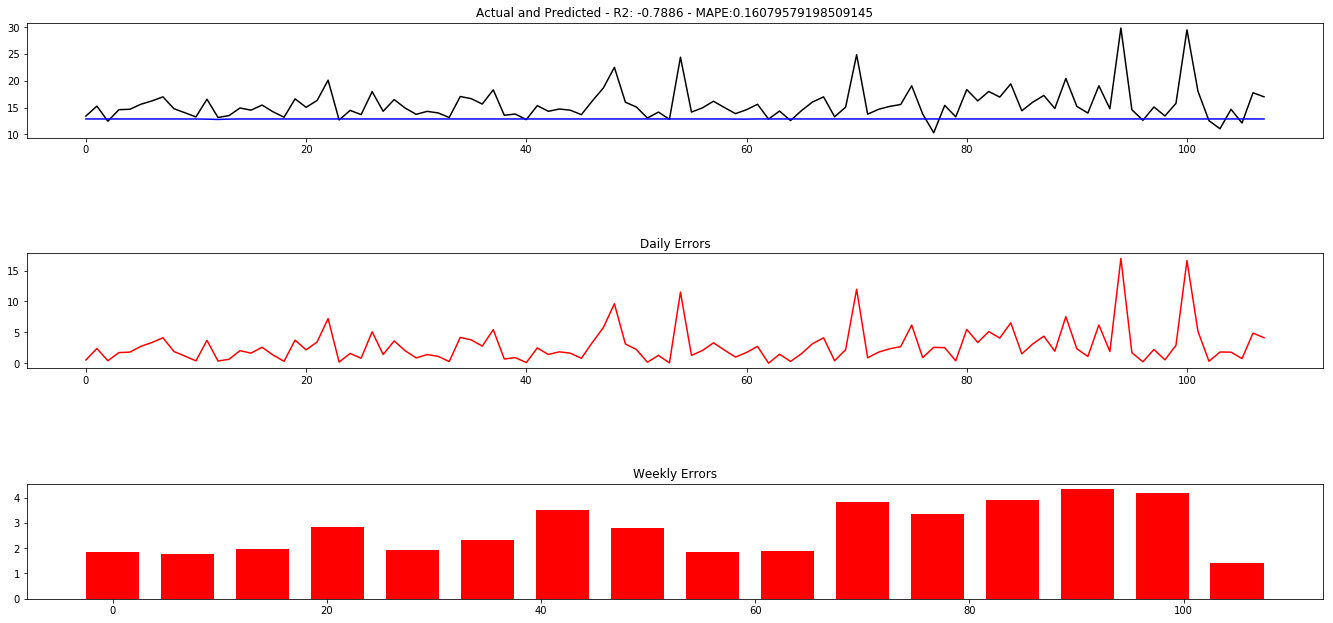

In [39]:
plot_prediction(Y_val_, model.predict(X_val_))

# Test Non-Normalized Model

In [40]:
X_test_ = test_data_dict[w]['X']
Y_test_ = test_data_dict[w]['Y']

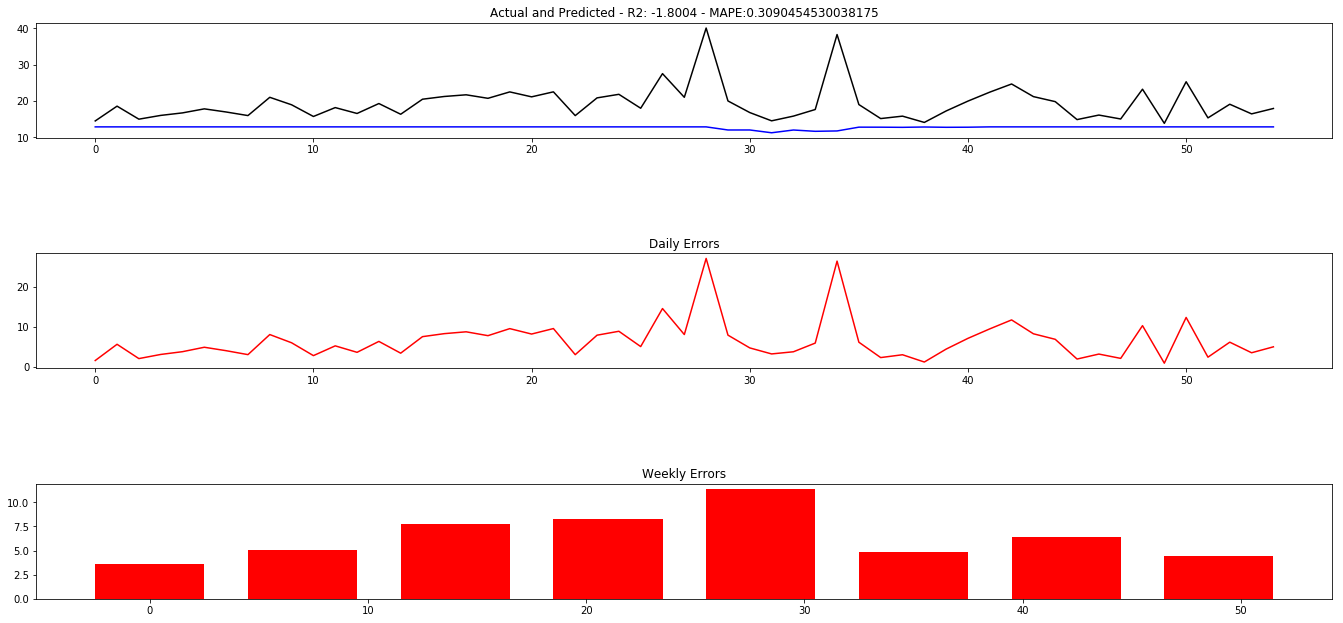

In [41]:
pred_y_ = model.predict(X_test_)
plot_prediction(Y_test_, pred_y_)

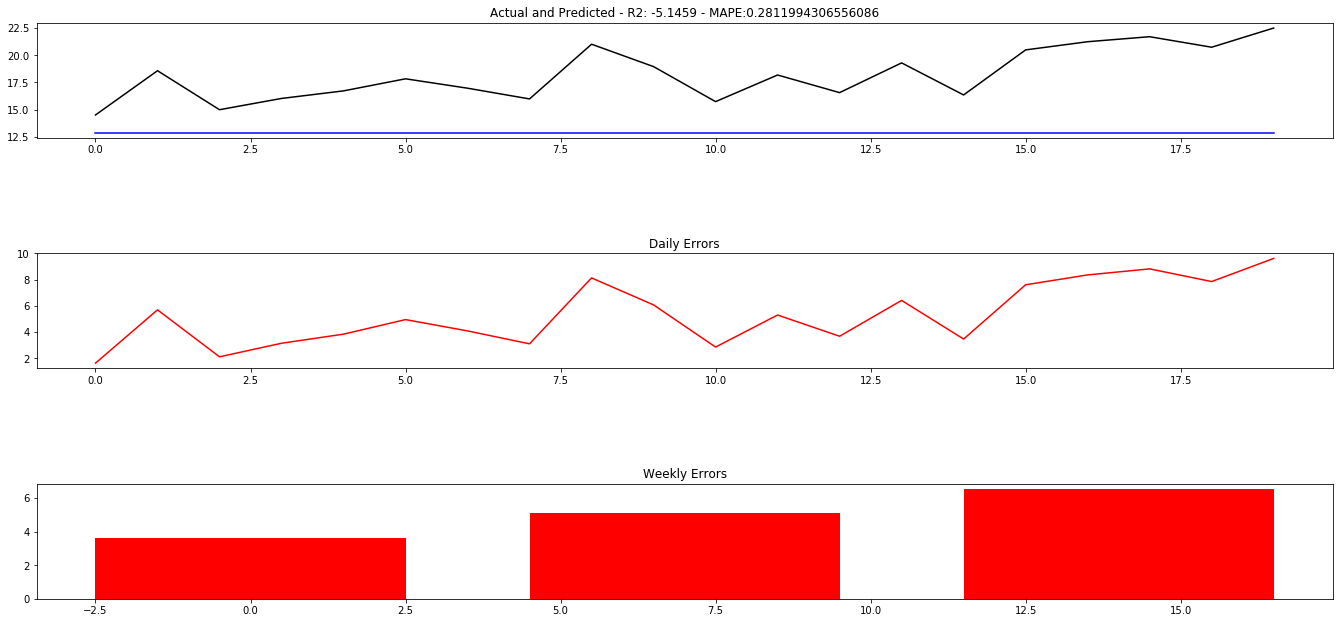

In [42]:
t=0
tp = 20
plot_prediction(Y_test_[t:t+tp], pred_y_[t:t+tp])